# Operations with Tree Tensor Networks

Import libraries

In [1]:
import numpy as np
import time
import h5py
import scipy
import copy
from numba import jit
import matplotlib.pyplot as plt 
%matplotlib inline

Import PyTTN dependencies

In [2]:
from pyttn import *

# Function to visualise tree diagrams
from pyttn.utils import visualise_tree

### Contents


1. [Preparation](#preparation)

    - [Preparing Tree Tensor Networks](#prepare-tree-tensor-network)

    - [Set Initial State of TTN](#set-initial-state-of-ttn)

2. [Visualising a State](#visualising-a-tree-tensor-network)

3. [Applying Operators to States](#applying-operators-to-states)

4. [Calculating Observables](#calculating-observables)

    - [Overlap](#calculating-overlap-of-two-tree-tensor-networks)

    - [Expectation values and matrix elements](#expectation-values-and-matrix-elements)

5. [Normalising a TTN](#normalising-a-ttn)

6. [Orthogonality and Orthogonality Centre](#orthogonality-and-orthogonality-centre)

### Preparation

##### Prepare Tree Tensor Network

To prepare a Tree Tensor Network, it is necessary to set up the topology of the tree. There is a detailed guide on how to do this in the tutorial [tree_generation.ipynb](files/../tree_topologies.ipynb).

ntree : (1(8(8(8(10(15))(10(15)))(10(15)))(8(10(15))(10(15))))(8(8(8(10(15))(10(15)))(10(15)))(8(10(15))(10(15)))));



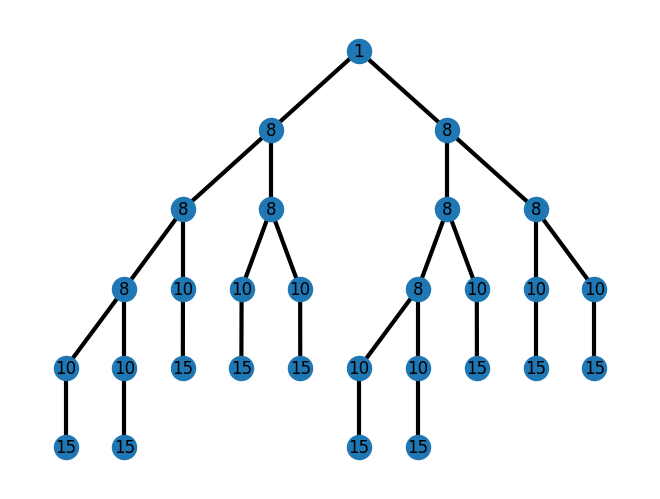

In [3]:
# Number of physical degrees of freedom
N = 10

# Maximum bond dimension
chi = 8

# Vector of dimensions of the local Hilbert space in the physical nodes
dims = [15 for _ in range(N)]

# Vector of dimensions of the basis transformation nodes
basis_nodes_dims = [10 for _ in range(N)]

# Max number of child nodes for each node. Always larger than 1
degree = 2


# Set up the tree topology
topo = ntreeBuilder.mlmctdh_tree(dims, degree, chi, basis_nodes_dims)
print(topo)

# Plot tree diagram
visualise_tree(topo)
plt.show()

And from it, create the Tree Tensor Network:

In [4]:
A = ttn(topo, dtype = np.complex128)

This creates a tree tensor network, where the bond dimension between a node and a root is given by the integer connecting the node to the root.  In this example, we have constructed a TTN object, where each of the tensors in the Tree Tensor Network have been allocated with enough memory to exactly handle the specified bond dimensions.  When working with adaptive bond dimension techniques, pyTTN only perform bond dimension expansion provided the Tensor Network object has enough memory to store the expanded bond dimension tensors.  In order to allocate larger tensor than are required by the topology `ntree` object the `ttn` function also accepts an optional capacity `ntree` that will be used in allocating the tensor object:

In [5]:
# Number of physical degrees of freedom
N = 10

# Bond dimension of State
chi = 8

#Maximum allowed bond dimension of state
chi_capacity = 32

# Vector of dimensions of the local Hilbert space in the physical nodes
dims = [15 for _ in range(N)]

# Vector of dimensions of the basis transformation nodes
basis_nodes_dims = [10 for _ in range(N)]

# Max number of child nodes for each node. Always larger than 1
degree = 2


# Set up the tree topology and tree capacity
topo = ntreeBuilder.mlmctdh_tree(dims, degree, chi, basis_nodes_dims)
capacity = ntreeBuilder.mlmctdh_tree(dims, degree, chi_capacity, basis_nodes_dims)

# Allocate the tree tensor network object allowing for larger tensor than are required to store topo
A = ttn(topo, capacity, dtype = np.complex128)

When working with the resultant `ttn` object, the tensors will be treated as if they have the size defined in `topo`.

##### Set initial state of TTN

There are several pre-defined functions to set the initial value of the Tree Tensor Network. A useful one is to initialise it to a random state.

One can create different random state with different seeds. The function `set_seed()` takes an integer which is used as the seed of the random number generator.

In [6]:
# Create Tree Tensor Network
A = ttn(topo)

# Initialise to a random state
A.random()

# Initialise to a random state with a different seed
A.set_seed(4)
A.random()

Another alternative is to initialise the TTN to a specific Fock state on each physical site. This can be done with the function `set_state()`.

In [7]:
# Create Tree Tensor Network
A = ttn(topo)

# Set wavefunction to the |0> state on all sites
A.set_state([0 for _ in range(N)])

# Set wavefunction to the |1> state on all sites
A.set_state([1 for _ in range(N)])

The function `zero()` sets all tensors in the network to be zero tensors.

In [8]:
# Create Tensor Network
A = ttn(topo)

# Set all tensors to be zero tensors
A.zero()

### Visualising a Tree Tensor Network

We can visualise the ttn using the `visualise_tree` function.  As a first example, we will visualise the `ttn` constructed above plotting its bond dimensions.  

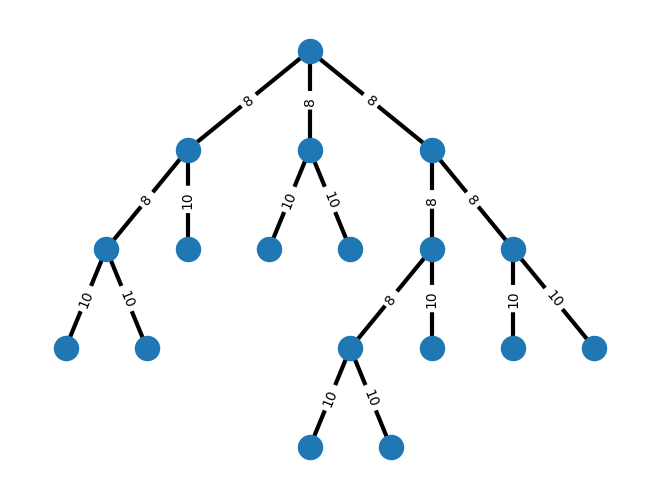

In [9]:
A = ttn(topo, capacity, dtype = np.complex128)

visualise_tree(A, bond_prop="bond dimension", label_all_bonds=True, colourmap=None)
plt.show()

We can also visualise the capacity of the `ttn` object by passing `bond_prop="bond capacity"`.

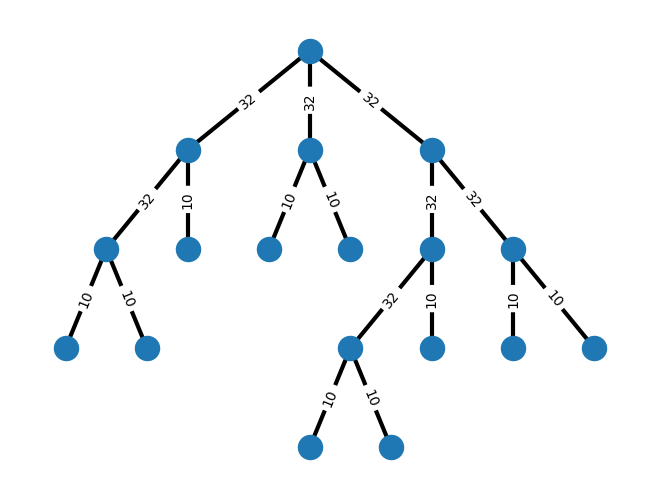

In [10]:
visualise_tree(A, bond_prop="bond capacity", label_all_bonds=True, colourmap=None)
plt.show()

Additionally, if we set colourmap to a valid `matplotlib` colormap name.  We can colour bonds based on the value of the `bond_prop`.

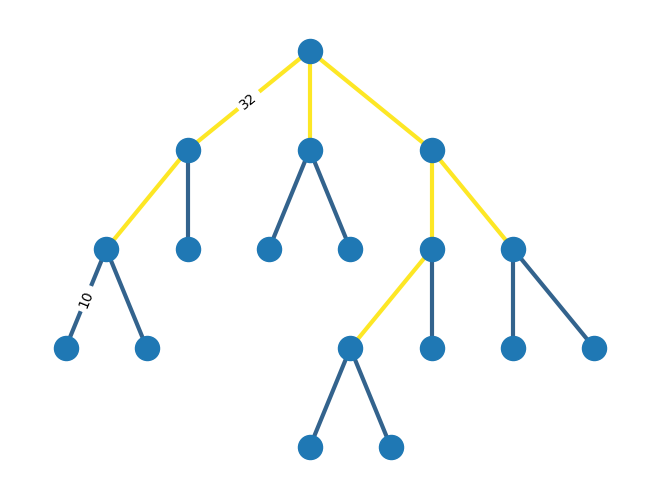

In [11]:
visualise_tree(A, bond_prop="bond capacity", colourmap='viridis')
plt.show()

### Applying operators to states

Creating one-site operators only requires the site operator `sOP` object and the information about the modes contained in `sysinf`. The function `site_operator` combines them to create an operator that can be directly used to perform operations with the TTN. 

A simple many-body operator can also be created from a site product of operators `sPOP` using the function `product_operator`. For more information on the different kinds of operators and how to generate them, read the [tutorial on operator generation](files/../operator_generation.ipynb).

In [12]:
# Initialise system information variable
sysinf = system_modes(N)

# Specify that all modes are bosonic, with Hilbert space dimensions defined above.
for i in range(N):
    sysinf[i] = boson_mode(dims[i])

There are several simple ways of applying single-site operators to states. They are all completely equivalent:

In [13]:
# Create TTN and initialise to random state
A = ttn(topo)
A.random()

# Create single-site operator
adag_2 = site_operator(sOP("adag", 2), sysinf)


# Apply site operator to TTN in equivalent ways
A.apply_one_body_operator(adag_2)
A.apply_operator(adag_2)
A = adag_2 @ A
A @= adag_2

Simple many-body operators are applied to states in a similar way. There are also several equivalent ways:

In [14]:
# Create TTN and initialise to random state
A = ttn(topo)
A.random()

# Create many-body operator
adag_3_a_5_adag_8 = product_operator(sPOP([sOP("adag",3), sOP("a",5), sOP("adag",8)]), sysinf)


# Apply product operator to TTN in equivalent ways
A.apply_product_operator(adag_3_a_5_adag_8)
A.apply_operator(adag_3_a_5_adag_8)
A = adag_3_a_5_adag_8 @ A
A @= adag_3_a_5_adag_8

Additionally, general operators (represented as `sop_operator`s) can be applied in a similar way:

In [15]:
# Create TTN and initialise to random state
A = ttn(topo)
A.random()

# Create sop_operator
H = SOP(N)

H += 2*sOP("n", 4)
H += 2*sOP("n", 5)
H += 5*sOP("a", 4)*sOP("adag",5)
H += 5*sOP("adag", 4)*sOP("a",5)

h = sop_operator(H, A, sysinf)

# Apply product operator to TTN in equivalent ways
A = h @ A

### Calculating Observables

PyTTN supports calculations of overlaps $\langle A | B \rangle$ between two different Tree Tensor Networks, of expectation values of operators $\langle A | \hat{O} | A \rangle$, and matrix elements of operators $\langle A | \hat{O} | B \rangle$. At the core of these calculations is the `matrix_element` engine, which can be used to perform all of them. 

When the `matrix_element` engine is initialised without an argument, it automatically adapts to the dimension of the TTN. The engine can also be initialised by passing a TTN in its arguments, to allocate memory prior to any matrix element evaluation.  

When evaluating matrix elements pyTTN will, when possible, avoid evaluating contractions that will trivial result in the identity matrix.  This arises when evaluating the norm of `ttn` objects with well defined orthogonality centres, or expectation values of `site_operator`s and `product_operator`s with respect to `ttn`s with well defined orthogonality centres.  In this case, it is only necessary to evaluate contractions over nodes in the tree connecting the orthogonality centre, to the non-identity site operators specified by the `site_operator` or `product_operator` objects.

##### Calculating overlap of two Tree Tensor Networks


The simplest calculation that can be performed with the `matrix_element` engine is the overlap of a TTN with itself. This can be useful to calculate norms:

In [16]:
# Create TTN and initialise to random state
A = ttn(topo)
A.random()

# Initialise engine to evaluate matrix elements
mel = matrix_element(A)

# Calculate overlap of the TTN with itself
print("<A|A>: ", mel(A))

<A|A>:  0.9999999999999998


The result is more interesting when the TTN is not normalised. As an example below, a creation operator is applied to the TTN in a random state, which leaves the TTN un-normalised.

In [17]:
# Create TTN and initialise to random state
A = ttn(topo)
A.random()

# Create operator and apply to TTN: obtain un-normalised state
op = site_operator(sOP("adag",7), sysinf)
A @= op


# Initialise engine to calculate matrix elements
mel = matrix_element()

# Calculate overlap of the un-normalised TTN with itself
print("<A|A>: ", mel(A))
print("Norm of A: ", np.sqrt(mel(A)))

# Calculate norm of TTN in an equivalent way
print("Norm of A: ", A.norm())

<A|A>:  6.751936833181954
Norm of A:  2.5984489283382026
Norm of A:  2.5984489283382035


The overlap of two Tree Tensor Networks can be calculated in a similar way: by initialising the `matrix_element` engine, and passing the two TTNs as its arguments.

In [18]:
# Create TTN and initialise to a random state
A = ttn(topo)
A.set_seed(np.random.randint(1,5))
A.random()

# Create TTN and initialise to a different random state
B = ttn(topo)
B.set_seed(np.random.randint(6,10))
B.random()


# Initialise engine to calculate matrix elements
mel = matrix_element()

# Calculate overlap between the two TTNs
print("<A|B>: ", mel(A,B))

<A|B>:  (4.400168478613747e-07-7.429725119316102e-07j)


This can be used to calculate overlap of a Tree Tensor Network with itself at two different points in time. To set up this calculation, the code below creates a copy `B = A(t)` of the TTN `A` and time-evolves it under the Hamiltonian $\hat{H} = 2\hat{n}_4 + 2\hat{n}_5 + 5\hat{a}_4\hat{a}^{\dagger}_5 + 5\hat{a}^{\dagger}_4\hat{a}_5$:

In [19]:
# Create TTN and initialise to a random state
A = ttn(topo)
A.random()

# Create B = A(t), copy of A that will be time evolved
B = copy.deepcopy(A)

# Calculate matrix element
mel = matrix_element()
print("<A|A(0)>:   ", mel(A, B))



# Create Hamiltonian for time evolution
H = SOP(N)

H += 2*sOP("n", 4)
H += 2*sOP("n", 5)
H += 5*sOP("a", 4)*sOP("adag",5)
H += 5*sOP("adag", 4)*sOP("a",5)

h = sop_operator(H, A, sysinf)



# Initialise time-evolution engine
sweep = tdvp(B, h, krylov_dim = 12, expansion='subspace')
sweep.coefficient = -1.0j
sweep.dt = 1e-2

# Perform time evolution
for i in range(1,10):
    sweep.step(B, h)
    print("<A|A(%i*dt)>:" % i, mel(A, B))

<A|A(0)>:    (0.9999999999999989+7.388774278017669e-19j)
<A|A(1*dt)>: (0.9509424640787756-0.2803348230450686j)
<A|A(2*dt)>: (0.8116126226305453-0.5238726032009149j)
<A|A(3*dt)>: (0.6038887201561633-0.7005391009694028j)
<A|A(4*dt)>: (0.3592676485252476-0.7921697271072393j)
<A|A(5*dt)>: (0.11272172093846619-0.7951170252781722j)
<A|A(6*dt)>: (-0.1037837999947111-0.7198342304628164j)
<A|A(7*dt)>: (-0.2666993056542601-0.5877020581633899j)
<A|A(8*dt)>: (-0.3641431789387258-0.42598264894305327j)
<A|A(9*dt)>: (-0.39648855424618656-0.26215044461700227j)


##### Expectation values and matrix elements

The `matrix_element` engine can also be used to calculate expectation values of operators $\langle A | \hat{O} | A \rangle$ and matrix elements of operators $\langle A | \hat{O} | B \rangle$. The operators $\hat{O}$ may be one-body or many-body operators, and they must be initialised as Tree Tensor Network Operators before being used to calculate the expectation values. For a detailed explanation on how to set up operators, read the [tutorial on operator generation](file/../operator_generation.ipynb).

The expectation value of a one-body operator $\hat{a}_3$, acting on index `3`, can be calculated as below:

In [20]:
# Create TTN and initialise to a random state
A = ttn(topo)
A.random()

# Create one-body operator
op = site_operator(sOP("a",3), sysinf)

# Calculate expectation value
mel = matrix_element()
print("<A|a_3|A>: ", mel(op, A))

<A|a_3|A>:  (-0.10321233219865554-0.05288388080040892j)


The same procedure can be followed to calculate the expectation value $\langle A | \hat{H} | A \rangle$ of a complex many-body operator, like the Hamiltonian $\hat{H} = 2\hat{n}_4 + 2\hat{n}_5 + 5\hat{a}_4\hat{a}^{\dagger}_5 + 5\hat{a}^{\dagger}_4\hat{a}_5$:

In [21]:
# Create TTN and initialise to a random state
A = ttn(topo)
A.random()

# Create Hamiltonian as SOP object
H = SOP(N)

# Add terms to Hamiltonian
H += 2*sOP("n", 4)
H += 2*sOP("n", 5)
H += 5*sOP("a", 4)*sOP("adag",5)
H += 5*sOP("adag", 4)*sOP("a",5)

# Initialise Hamiltonian as TTNO
h = sop_operator(H, A, sysinf)

# Calculate expectation value
mel = matrix_element()
print("<A|H|A>: ", mel(h, A))

<A|H|A>:  (28.670466077053682+1.220811646218678e-16j)


A similar procedure can be followed to calculate matrix elements $\langle A | \hat{O} | B \rangle$ of operators $\hat{O}$. For example, in the Fock basis, the matrix element $\,$ $_4\langle 1 | \hat{a}_4 | 2 \rangle_4 = \sqrt{2}$.

In [22]:
# Create TTN and initialise to a random state
A = ttn(topo)
A.set_state([0,0,0,0,1,0,0,0,0,0])

# Create TTN and initialise to a different random state
B = ttn(topo)
B.set_state([0,0,0,0,2,0,0,0,0,0])

# Create one-site operator
op = site_operator(sOP("a",4), sysinf)

# Calculate matrix element
mel = matrix_element()
print("<A|a_4|B>: ", mel(op, A, B))

<A|a_4|B>:  (1.4142135623730951+0j)


And it is similarly easy to calculate a 2-point correlator $\langle A | \hat{O}(0) \hat{O}(t) | A \rangle$. For this calculation, the state $|B(t)\rangle = \hat{O}(t) |A\rangle$ is time-evolved under the Hamiltonian $\hat{H} = 2\hat{n}_4 + 2\hat{n}_5 + 5\hat{a}_4\hat{a}^{\dagger}_5 + 5\hat{a}^{\dagger}_4\hat{a}_5$, and the resulting state is used to calculate the matrix element $\langle A | \hat{O}(0) | B(t) \rangle = \langle A | \hat{O}(0) \hat{O}(t) | A \rangle$.

In [23]:
# Create TTN and initialise to a random state
A = ttn(topo)
A.random()

# Create one-site operator
op = site_operator(sOP("n",4), sysinf)

# Create B = n_4(t) @ A, that will be time evolved
B = copy.deepcopy(A)
B @= op

# Calculate matrix element
mel = matrix_element()
print("<A|n_4(0)n_4(0)|A>:   ", mel(op, A, B))



# Create Hamiltonian for time evolution
H = SOP(N)

H += 2*sOP("n", 4)
H += 2*sOP("n", 5)
H += 5*sOP("a", 4)*sOP("adag",5)
H += 5*sOP("adag", 4)*sOP("a",5)

h = sop_operator(H, A, sysinf)



# Initialise time-evolution engine
sweep = tdvp(B, h, krylov_dim = 12, expansion='subspace')
sweep.coefficient = -1.0j
sweep.dt = 1e-2

# Perform time evolution
for i in range(1,10):
    sweep.step(B, h)
    print("<A|n_4(0)n_4(%i*dt)|A>:" % i, mel(op, A, B))

<A|n_4(0)n_4(0)|A>:    (72.68572937050456+3.41740524767431e-16j)
<A|n_4(0)n_4(1*dt)|A>: (67.48099520312208-25.6687100272462j)
<A|n_4(0)n_4(2*dt)|A>: (52.85655707835799-47.01734127702919j)
<A|n_4(0)n_4(3*dt)|A>: (31.579213985938857-60.61731704891346j)
<A|n_4(0)n_4(4*dt)|A>: (7.588061574538952-64.63947145729138j)
<A|n_4(0)n_4(5*dt)|A>: (-14.877617339991518-59.19284956566202j)
<A|n_4(0)n_4(6*dt)|A>: (-32.202210586332065-46.20677434090808j)
<A|n_4(0)n_4(7*dt)|A>: (-42.13722867825736-28.887605001059043j)
<A|n_4(0)n_4(8*dt)|A>: (-44.17653721442998-10.897140522293753j)
<A|n_4(0)n_4(9*dt)|A>: (-39.47667230488788+4.522006848151942j)


### Normalising a TTN

The function `norm()` calculates the norm of the Tree Tensor Network:

In [24]:
# Create TTN and initialise to a random state
A = ttn(topo)
A.random()

# Calculate norm of TTN
A.norm()

0.9999999999999999

An un-normalised Tree Tensor Network can be normalised using a single function. As an example, let us prepare an un-normalised TTN:

In [25]:
# Create one-body operator and apply it to TTN
op = site_operator(sOP("a",7), sysinf)
A.apply_one_body_operator(op)

# Calculate norm of TTN
A.norm()

2.634199568224364

And normalise it using the function `normalise()`:

In [26]:
A.normalise()

# Calculate norm of TTN
A.norm()

1.0

### Orthogonality and Orthogonality Centre

pyTTN is designed to handle internally operations affecting the orthogonality centre of the network. However, there are several functionalities to control the orthogonality centre that may be useful for the advanced user.

For the following discussion, it will be useful to recall the tree diagram:

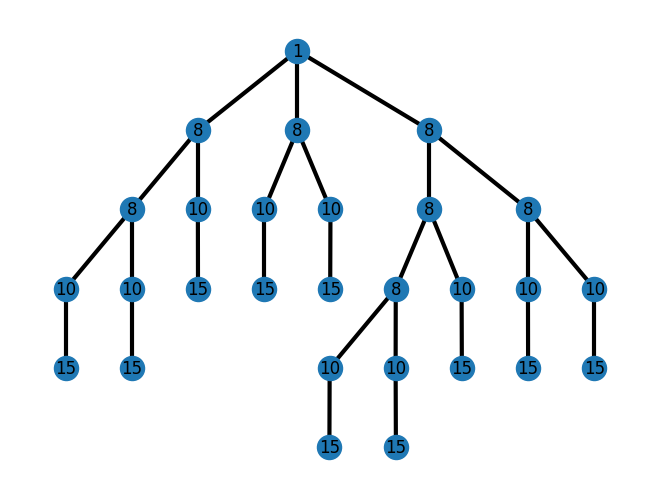

In [27]:
# Create TTN and initialise to random state
A = ttn(topo)
A.random()

# Optimise tree diagram
ntreeBuilder.sanitise(topo)

# Plot diagram of TTN topology
visualise_tree(topo)

In the tree diagram above, the nodes with bond dimension `8` are internal nodes of the TTN; the nodes with Hilbert-space dimension `15` are "physical nodes", encoding the degrees of freedom of the problem; and the nodes with dimension `10` are local Hilbert-space rotations. The node with dimension `1` is the root of the tree—for more information on the topoogy of the network, read the [tutorial on generating tree topologies](files/../tree_topologies.ipynb). 

pyTTN uses *pre-order depth-first* ordering, a method of visiting all the nodes of the tree by exploring as far as possible along a branch (_depth-first_) before backtracking, starting from the root (_pre-order_). The branches are visited from left to right. 

The nodes of the network are indexed according to this ordering, although ignoring the local basis-rotation nodes. This is because those can be contracted to the leaf nodes without altering the topology of the network. Note that the index of the node in the network is not the same as the index corresponding to the physical degree of freedom. The physical index is the one specified when applying operators to the Tree Tensor Network.

The function `orthogonality_centre()` indicates the index of the TTN where the orthogonality centre is. The network is orthogonalised when the orthogonality centre is at the root node, with index `0`.

In [28]:
A.orthogonality_centre()

0

The function `is_orthogonalised()` is a Boolean test of the orthogonality of the TTN:

In [29]:
A.is_orthogonalised()

True

When an operator acts on the TTN, the orthogonality centre is shifted to the index upon which the operator acts. 

Note that the operator is created specifying a physical index (in this case, leaf node `3`), which corresponds to a different network index (in this case, network node `7`). The reader can convince themself of this by counting the nodes in _pre-order depth-first_ ordering, remembering to ignore the local basis rotation nodes, starting from the root node `0`, and finding that the network node `7` is the same as the physical node `3`.

In [30]:
op = site_operator(sOP("adag",3), sysinf)
A.apply_one_body_operator(op)

# Orthogonality information
print("Orthogonality centre: ", A.orthogonality_centre())
print("Is orthogonalised: ", A.is_orthogonalised())

Orthogonality centre:  7
Is orthogonalised:  False


The function `orthogonalise` sets the orthogonality centre back at the root of the tree.

In [31]:
A.orthogonalise()

# Orthogonality information
print("Orthogonality centre: ", A.orthogonality_centre())
print("Is orthogonalised: ", A.is_orthogonalised())

Orthogonality centre:  0
Is orthogonalised:  True


The user can set the orthogonality centre manually in several ways.

The function `set_orthogonality_centre()` moves the orthogonality centre to the node indicated in its argument. This can be specified in two ways: by indicating a network index, or by indicating the path to a network node. Both ways are exemplified below. 

The path to a node is a vector containing the index of the branch that one has to follow from the root node `0` to arrive at a specified node. For instance, the path `[0,0,1]` specifies the physical node `1`, which can be found by starting at the root and moving to its left-most branch, then again to its left-most branch, and finally taking the right branch to arrive at the leaf node `topo()[0][0][1]`.

In [32]:
print("Orthogonality centre: ", A.orthogonality_centre())

# Set orthogonality centre at site 2
A.set_orthogonality_centre(2)
print("Orthogonality centre: ", A.orthogonality_centre())

# Set orthogonality centre at site 7
# topo()[1][0]
A.orthogonalise()
A.set_orthogonality_centre([1,0])
print("Orthogonality centre: ", A.orthogonality_centre())

Orthogonality centre:  0
Orthogonality centre:  2
Orthogonality centre:  7


The function `shift_orthogonality_centre()` moves the orthogonality centre in the tree relative to its current position. Its argument indicates the direction in which the orthogonality centre shifts, by specifying the branch along which to move. The parent branch of a node is `0`, and the child branches are numbered from left to right. 

Below is an example of shifting the orthogonality centre. To follow its displacement, it is useful to look at the tree diagram.

Orthogonality centre:  6
Orthogonality centre:  7
Orthogonality centre:  6
Orthogonality centre:  0
Orthogonality centre:  1
Orthogonality centre:  2
Orthogonality centre:  0
Orthogonality centre:  6


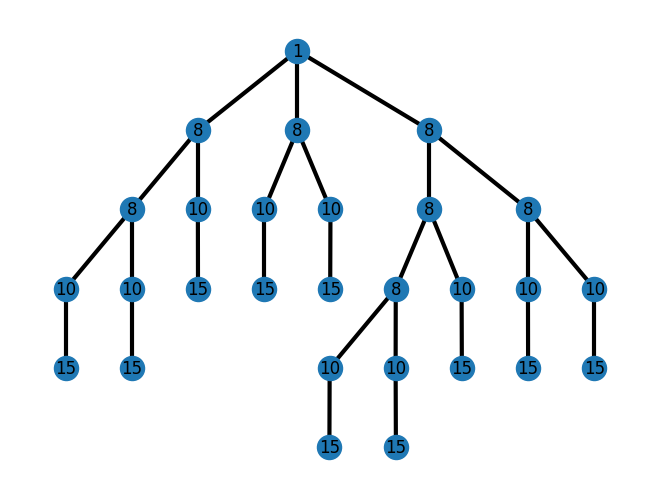

In [33]:
# Plot diagram of TTN topology
visualise_tree(topo)

# Set orthogonality centre at node 6
A.set_orthogonality_centre(6)
print("Orthogonality centre: ", A.orthogonality_centre())

# Move orthogonality centre to node 7
A.shift_orthogonality_centre(1)
print("Orthogonality centre: ", A.orthogonality_centre())

# Move orthogonality centre back to node 6
A.shift_orthogonality_centre(0)
print("Orthogonality centre: ", A.orthogonality_centre())

# Move orthogonality centre to node 0
A.shift_orthogonality_centre(0)
print("Orthogonality centre: ", A.orthogonality_centre())

# Move orthogonality centre to node 1
A.shift_orthogonality_centre(0)
print("Orthogonality centre: ", A.orthogonality_centre())

# Move orthogonality centre to node 2
A.shift_orthogonality_centre(1)
print("Orthogonality centre: ", A.orthogonality_centre())

# Set orthogonality centre at node 1
A.set_orthogonality_centre(0)
print("Orthogonality centre: ", A.orthogonality_centre())

# Move orthogonality centre to node 6
A.shift_orthogonality_centre(1)
print("Orthogonality centre: ", A.orthogonality_centre())